In [2]:
import numpy as np
import dadi
import random
import pickle
import os, sys
sys.path.append(os.path.join(os.getcwd(), '..')) # this is the ml_dadi dir
from data_manip import generating_data
import math

In [33]:
def generate_data_1d_2epoch_unnorm(n_samples, theta_list, sample=False):
    # generate params
    params_dict = {}

    while len(params_dict) < n_samples:
        log_theta = random.random() * 3 + 2
        log_nu = random.random() * 4 - 2
        T = random.random() * 1.9 + 0.1
        params_dict[(log_nu, T)] = log_theta

    print(f'n_samples={len(params_dict)}')

    # designate demographic model, sample size, and extrapolation grid
    func = dadi.Demographics1D.two_epoch
    ns = [20]
    pts_l = [40, 50, 60]
    # theta_list = [1]
    # specify param in log scale
    logs = [True, False]

    # generate data
    data = generating_data(
        list(params_dict.keys()), theta_list, func, ns, pts_l, logs)

    # make new dict with new labels (log_theta, log_nu, T)
    data_dict = {}
    # also need to times fs by unlog theta

    # right now we have two dicts: params_dict and data[0]
    # both have n_samples items and same log_nu, T tuple as keys
    for key in list(params_dict.keys()):
        log_theta = params_dict[key]
        theta = 10**log_theta
        # make a new tuple key with log_nu, T and theta
        # this will be our new training label
        new_key = tuple([log_theta]) + key
        # print(new_key)

        # # convert nu and T
        # new_nu = math.log10(10**key[0] * theta / 4)
        # new_T = key[1] * theta / 2
        # # new_key = new_nu, new_T, log_theta
        # new_key = new_nu, new_T

        # make new fs using unlog theta
        fs = data[0][key]
        if sample:
            scaled_fs = (fs * theta).sample()
        else:
            scaled_fs = fs * theta

        # store into new data dict
        data_dict[new_key] = scaled_fs

    return data_dict

In [12]:
train_data = generate_data_1d_2epoch_unnorm(1000, [1])


n_samples=1000


In [15]:
test_data_1 = generate_data_1d_2epoch_unnorm(100, [1])

n_samples=100


In [34]:
test_data_2 = generate_data_1d_2epoch_unnorm(100, [1], sample=True)

n_samples=100


In [43]:
pickle.dump(test_data_2, open('data/1d_2epoch/theta_test_data_2', 'wb'), 2)

In [52]:
# make test_data_3 (sampled not normalized)
def generate_data_1d_2epoch_unnorm(n_samples, theta_list):
    # generate params
    params = []

    while len(params) < n_samples:
        log_nu = random.random() * 4 - 2
        T = random.random() * 1.9 + 0.1
        params.append((log_nu, T))

    print(f'n_samples={len(params)}')

    # designate demographic model, sample size, and extrapolation grid
    func = dadi.Demographics1D.two_epoch
    ns = [20]
    pts_l = [40, 50, 60]
    # specify param in log scale
    logs = [True, False]

    # generate data
    data = generating_data(params, theta_list, func, ns, pts_l, logs, norm=False)
    return data
test_data_3 = generate_data_1d_2epoch_unnorm(100, [10000, 1000, 100])

n_samples=100


In [78]:
# make test_data_4 (not sampled)
def generate_data_1d_2epoch_unnorm(n_samples, theta_list):
    # generate params
    params = []

    while len(params) < n_samples:
        log_nu = random.random() * 4 - 2
        T = random.random() * 1.9 + 0.1
        params.append((log_nu, T))

    print(f'n_samples={len(params)}')

    # designate demographic model, sample size, and extrapolation grid
    func = dadi.Demographics1D.two_epoch
    ns = [20]
    pts_l = [40, 50, 60]
    # specify param in log scale
    logs = [True, False]

    # generate data
    data = generating_data(params, theta_list, func, ns, pts_l, logs, sample=False, norm=False)
    return data
test_data_4 = generate_data_1d_2epoch_unnorm(100, [10000, 1000, 100])

n_samples=100


In [54]:
pickle.dump(test_data_3, open('data/1d_2epoch/theta_test_data_3', 'wb'), 2)

In [79]:
pickle.dump(test_data_4, open('data/1d_2epoch/theta_test_data_4', 'wb'), 2)

In [16]:
pickle.dump(train_data, open('data/1d_2epoch/theta_train_data', 'wb'), 2)
pickle.dump(test_data_1, open('data/1d_2epoch/theta_test_data', 'wb'), 2)

In [17]:
# unpack train data set
X_train = [train_data[params].data.flatten()
           for params in train_data]

y_train = [params for params in train_data]
# separate each param
theta_train = [params[0] for params in y_train]
# nu_train = [params[1] for params in y_train]
# T_train = [params[2] for params in y_train]

In [24]:
from mapie.regression import MapieRegressor
from sklearn.neural_network import MLPRegressor
# implementing MAPIE train
mlpr = MLPRegressor(hidden_layer_sizes=(500,), activation='tanh',
                            solver='lbfgs', max_iter=10000, tol=1e-1)

# for theta
mapie_theta = MapieRegressor(mlpr)
mapie_theta.fit(X_train, theta_train)

MapieRegressor(estimator=MLPRegressor(activation='tanh',
                                      hidden_layer_sizes=(500,), max_iter=10000,
                                      solver='lbfgs', tol=0.1))

In [25]:
pickle.dump(mapie_theta, open('data/1d_2epoch/mapie_theta', 'wb'), 2)

In [103]:
# unpack test data set 1
X_test = [test_data_1[params].data.flatten()
          for params in test_data_1]
y_test = [params for params in test_data_1]
# separate each param
theta_test = [params[0] for params in y_test]
nu_test = [params[1] for params in y_test]
T_test = [params[2] for params in y_test]

In [116]:
# unpack test data set 2
X_test = [test_data_2[params].data.flatten()
          for params in test_data_2]
y_test = [params for params in test_data_2]
# separate each param
theta_test = [params[0] for params in y_test]
nu_test = [params[1] for params in y_test]
T_test = [params[2] for params in y_test]

In [123]:
# unpack test data set 3
i=0
theta_list = [10000, 1000, 100]
X_test = [test_data_3[i][params].data.flatten()
          for params in test_data_3[i]]
y_test = [params for params in test_data_3[i]]
# separate each param
theta_test = [math.log10(theta_list[i]) for _ in range(100)]
nu_test = [params[0] for params in y_test]
T_test = [params[1] for params in y_test]

In [93]:
# unpack test data set 4
i=0
theta_list = [10000, 1000, 100]
X_test = [test_data_4[i][params].data.flatten()
          for params in test_data_4[i]]
y_test = [params for params in test_data_4[i]]
# separate each param
theta_test = [math.log10(theta_list[i]) for _ in range(100)]
nu_test = [params[0] for params in y_test]
T_test = [params[1] for params in y_test]

In [124]:
# implementing MAPIE test
alpha = [0.05, 0.1, 0.2, 0.5, 0.7, 0.85]
# for nu
theta_pred, theta_pis = mapie_theta.predict(X_test, alpha=alpha)


An input array is constant; the correlation coefficent is not defined.

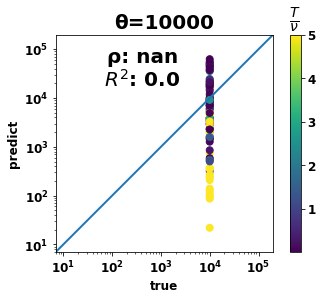

In [125]:
from matplotlib import pyplot as plt
from mapie.metrics import regression_coverage_score
import plotting
from plotting import plot_accuracy_single
import ml_models
T_over_nu = [T/10**nu for T,nu in zip(T_test, nu_test)]
theta_test_log = [10**p_true for p_true in theta_test]
theta_pred_log = [10**p_pred for p_pred in theta_pred]
r2 = ml_models.r2(theta_test_log, theta_pred_log)[0]
rho = ml_models.rho(theta_test_log, theta_pred_log)
plot_accuracy_single(theta_test_log, theta_pred_log, x_label="true",
                         y_label="predict", size=[6, 2, 20], log=True, r2=r2, rho=rho, title = f'θ={theta_list[i]}', c=T_over_nu)

In [126]:
theta_coverage_scores = [
    regression_coverage_score(theta_test, theta_pis[:, 0, i], theta_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]
theta_coverage_scores 

[0.7, 0.66, 0.61, 0.01, 0.0, 0.0]

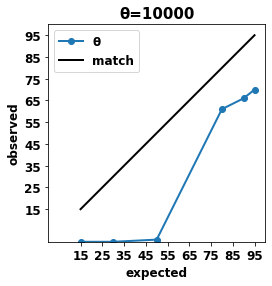

In [127]:
# plot coverage
expected = [95, 90, 80, 50, 30, 15]
# theta = 1000
params = ['θ']

observed = ([s*100 for s in theta_coverage_scores],)

fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal', 'box')
font = {'weight': 'bold', 'size': 12}
plt.rc('font', **font)

ax.set_title(f'θ={theta_list[i]}', fontsize=15, fontweight='bold')
ax.set_xlabel("expected", fontsize=12, fontweight='bold')
ax.set_ylabel("observed", fontsize=12, fontweight='bold')

for i in range(len(params)):
    ax.plot(expected, observed[i],
            label=params[i], marker='o', linewidth=2)
ax.plot(expected, expected, label='match', linewidth=2, color="black")

plt.xticks(np.arange(min(expected), max(expected)+5, 10))
plt.yticks(np.arange(min(expected), max(expected)+5, 10))
plt.xlim([0, 100])
plt.ylim([0, 100])

ax.legend()

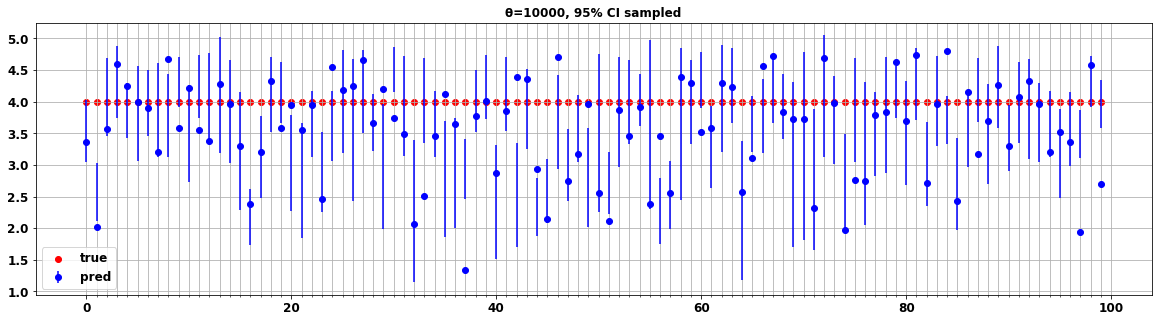

In [128]:
# plot 95% confidence interval
# theta = 100
params = ['θ']
theta_arr = np.array([theta_test, theta_pred, theta_pis[:, 0, 0], theta_pis[:, 1, 0]])
# sort by param
int_arr_all = [theta_arr.T.tolist()] # differs from Connie bootstrapping version: [true, pred, lower, upper]
size = 100
x = range(size)

# plot 95% confidence interval (cont.)
for param, int_arr in zip(params, int_arr_all):
    int_arr = np.array(int_arr[:size])
    int_arr = int_arr.transpose(1, 0)

    fig = plt.figure(figsize=(20, 5))
    # ax = fig.add_subplot(1, 1, 1)
    ax = plt.gca()
    minor_ticks = np.arange(0, size)
    major_ticks = np.arange(0, size, 10)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='both')

    ax.scatter(x, int_arr[0], c="red", label="true")
    # ax.scatter(x, int_arr[0], c=T_over_nu, vmax=5, label="true")
    neg_int = int_arr[1] - int_arr[2]
    pos_int = int_arr[3] - int_arr[1]
    ax.errorbar(x, int_arr[1], yerr=[
                neg_int, pos_int], fmt='bo', label = 'pred')
    # ax.errorbar(x, int_arr[1], yerr=[
    #             neg_int, pos_int], fmt='bo', label = 'pred', c="sienna")

    # ax.set_title(f'{param}, theta={theta_list[i]}', fontsize=12, fontweight='bold')
    ax.set_title(f'{param}=10000, 95% CI sampled', fontsize=12, fontweight='bold')
    ax.legend()